In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import re
#from unidecode import unidecode

import collections
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [3]:
#Importing the raw data containing tweets into dataframes
real = pd.read_csv('real.csv') # these are real news
fake = pd.read_csv('fake.csv') # these are fake news

In [4]:
real

,tweet
0,sun downs technical director: al-ahly respecte...
1,shawky gharib after the tie with enppi: our go...
2,"egyptian sports news today, wednesday 1/25/202..."
3,the main referees committee of the egyptian fo...
4,"haji bari, the striker of the future team, is ..."
...,...
21864,shawky gharib: we excluded 4 players from the ...
21865,dina musharraf resumes her career in the singa...
21866,"indeed, al-ahly ended its agreement with ricar..."
21867,"hazem imam, the captain of zamalek, decided to..."


In [5]:
fake

,tweet
0,"the tongue of his condition, now i saw things ..."
1,"by god the great, after i saw the derby of wyd..."
2,"believe in god, this zamalek fans are as good ..."
3,the coach appeared in the media and told the t...
4,asno smito\nwhoever knows her tells me a massa...
...,...
19986,by hitting the referee
19987,and instead of assassinating him.. they assass...
19988,"honestly, the goalkeeper deal is not the best\..."
19989,haha goal and no bangura (:


In [6]:
print(real.shape)
print(fake.shape)

(21869, 1)
(19991, 1)


#### We have around 20,000 values each of real and fake tweets to work with.

In [7]:
#Checking null values to remove them later
print(fake.isna().sum())
print(real.isna().sum())

tweet    3
dtype: int64
tweet    6
dtype: int64


In [8]:
#Assigning labels to fake and real news
#created a column called label,fake news have label=1 and real nwes have label=0

fake['label'] = 1
real['label'] = 0

In [15]:
#combining the two data sets into a single dataframe to work with 
df = pd.concat([real, fake], ignore_index = True)
df.head()

,tweet,label
0,sun downs technical director: al-ahly respecte...,0
1,shawky gharib after the tie with enppi: our go...,0
2,"egyptian sports news today, wednesday 1/25/202...",0
3,the main referees committee of the egyptian fo...,0
4,"haji bari, the striker of the future team, is ...",0


In [16]:
df.tail()

,tweet,label
41855,by hitting the referee,1
41856,and instead of assassinating him.. they assass...,1
41857,"honestly, the goalkeeper deal is not the best\...",1
41858,haha goal and no bangura (:,1
41859,i swear by god almighty\nmessi will not come t...,1


In [17]:
#removing the rows that contain null values
df = df.dropna()

In [18]:
df

,tweet,label
0,sun downs technical director: al-ahly respecte...,0
1,shawky gharib after the tie with enppi: our go...,0
2,"egyptian sports news today, wednesday 1/25/202...",0
3,the main referees committee of the egyptian fo...,0
4,"haji bari, the striker of the future team, is ...",0
...,...,...
41855,by hitting the referee,1
41856,and instead of assassinating him.. they assass...,1
41857,"honestly, the goalkeeper deal is not the best\...",1
41858,haha goal and no bangura (:,1


In [19]:
# Variable to replace all characters that are not letters or whitespace
regex = re.compile('[^a-z\s]')
# Convert text to lower case
df['text'] = df['tweet'].str.lower()
# Removes all characters that are not letters or spaces
#df['text'] = df['text'].apply(lambda x: regex.sub('', str(x)))
# Removes all characters between square brackets 
df['text'] = df['text'].str.replace('[%s]', '', regex = True)
# Remove the accents
#df['text'] = df['text'].apply(lambda x: regex.sub('', unidecode(x)))
# Remove http
df['text'] = df['text'].str.replace('http', '', regex = True)

In [20]:
df['text']

0        un down technical director: al-ahly repected u...
1        hawky gharib after the tie with enppi: our goa...
2        egyptian port new today, wedneday 1/25/2023, w...
3        the main referee committee of the egyptian foo...
4        haji bari, the triker of the future team, i un...
                               ...                        
41855                               by hitting the referee
41856    and intead of aainating him.. they aainated hi...
41857    honetly, the goalkeeper deal i not the bet\n _...
41858                          haha goal and no bangura (:
41859    i wear by god almighty\nmei will not come to a...
Name: text, Length: 41851, dtype: object

In [21]:
#tokenization
df['text'] = df['text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

#stemming
stemmer = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Joining the words back into a single text
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [22]:
#preprocessed text
df['text']

0            un technic director : al-ah repect u play win
1         hawki gharib tie enppi : goal return golden quar
2        egyptian port new today , wedneday 1/25/2023 ,...
3        main refere committe egyptian footbal aociat c...
4        haji bari , triker futur team , undergo final ...
                               ...                        
41855                                           hit refere
41856                     intead aainat .. aainat _ al-hil
41857                  honet , goalkeep deal bet _ al-fath
41858                                haha goal bangura ( :
41859    wear god almighti mei come audi arabia leagu r...
Name: text, Length: 41851, dtype: object

### Sentiment Analysis

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def sentiment_analysis(string):
    scores = sid.polarity_scores(string)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
df['comp_score'] = df['text'].apply(lambda x: sentiment_analysis(x))

In [24]:
df

,tweet,label,text,comp_score
0,sun downs technical director: al-ahly respecte...,0,un technic director : al-ah repect u play win,Positive
1,shawky gharib after the tie with enppi: our go...,0,hawki gharib tie enppi : goal return golden quar,Neutral
2,"egyptian sports news today, wednesday 1/25/202...",0,"egyptian port new today , wedneday 1/25/2023 ,...",Neutral
3,the main referees committee of the egyptian fo...,0,main refere committe egyptian footbal aociat c...,Negative
4,"haji bari, the striker of the future team, is ...",0,"haji bari , triker futur team , undergo final ...",Neutral
...,...,...,...,...
41855,by hitting the referee,1,hit refere,Neutral
41856,and instead of assassinating him.. they assass...,1,intead aainat .. aainat _ al-hil,Neutral
41857,"honestly, the goalkeeper deal is not the best\...",1,"honet , goalkeep deal bet _ al-fath",Neutral
41858,haha goal and no bangura (:,1,haha goal bangura ( :,Positive


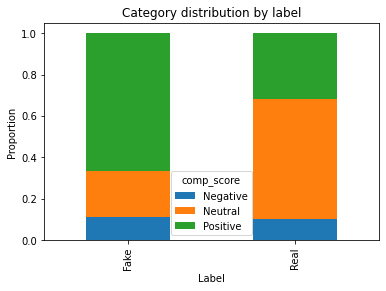

In [25]:
#graph for real data mentioning positive, negative, neutral
#graph for fake data mentioning positive, negative, neutral

# Map 0 to 'Real' and 1 to 'Fake'
df['tab'] = df['label'].map({0: 'Real', 1: 'Fake'})

# Compute the proportion of each category for the Real and Fake labels
freq_df = pd.crosstab(df['tab'], df['comp_score'], normalize='index')

# Create the stacked bar chart
freq_df.plot(kind='bar', stacked=True)
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.title('Category distribution by label')
plt.show()

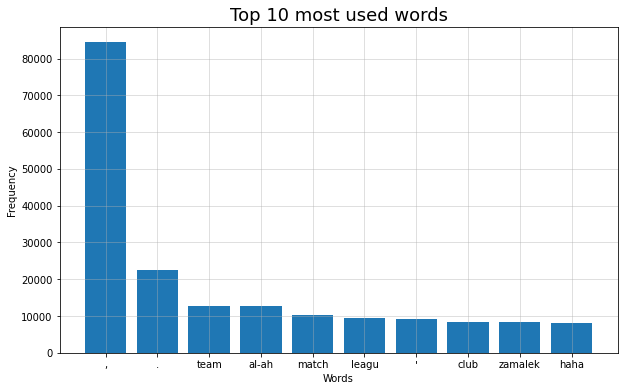

In [26]:
#Graph to display Top 10 most used words
words = []
for text in df['text']:
    words.extend(text.split())

word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))
# Grid Opacity
plt.grid(alpha = 0.5)
# Title
plt.title('Top 10 most used words', fontsize = 18)
# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')
# Show
plt.show()

In [27]:
# Split X and Y for modelling
x = np.array(df['text'])
y = np.array(df['label'])

# Convert text to numerical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vectorizer = CountVectorizer()
freq_term_matrix = count_vectorizer.fit_transform(x)
tfidf = TfidfTransformer()
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)


In [28]:
# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y, test_size = 0.33, random_state = 42)

In [29]:
#Different models for classification
models = [
          (LogisticRegression()),
          (DecisionTreeClassifier()),
          (RandomForestClassifier()),
          (SVC()), 
          (KNeighborsClassifier())
        ]

In [30]:
dfs = pd.DataFrame()

In [31]:
for model in models:
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        roc=roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results = pd.DataFrame([[model, acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
        dfs = pd.concat([results,dfs], ignore_index = True)
dfs

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,KNeighborsClassifier(),0.673738,0.594592,0.985068,0.741569,0.688450
1,SVC(),0.959670,0.949955,0.966022,0.957921,0.959970
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.948157,0.941150,0.950328,0.945716,0.948260
3,DecisionTreeClassifier(),0.892911,0.879516,0.897608,0.888470,0.893133
4,LogisticRegression(),0.951198,0.940859,0.957489,0.949101,0.951496


#### we conclude that SVC is the better one among the above as it clearly has better scores for almost all measures.